In [1]:
!nvidia-smi


Sun Apr 27 10:50:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000             WDDM  |   00000000:65:00.0  On |                  Off |
| 30%   51C    P5             30W /  300W |    2683MiB /  49140MiB |     59%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionXLPipeline
import logging
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
from PIL import Image
import time

# Set up logging
logging.basicConfig(level=logging.INFO)

In [ ]:

dataset_path = "Dataset"
metadata_file = "Dataset/dataset_labels.csv"
save_dir = "fine-tuned-weights"
image_size = 512
batch_size = 16
accumulation_steps = 4
learning_rate = 1e-5
num_epochs = 10

# Create save directory
os.makedirs(save_dir, exist_ok=True)

# Load dataframe
df = pd.read_csv(metadata_file)
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(dataset_path, x))

# Define transform
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset class (provided by user)
class JewelryDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        start_time = time.time()
        image_path = self.df.iloc[idx]["image_path"]
        prompt = self.df.iloc[idx]["description"]
        try:
            image = Image.open(image_path).convert("RGB")
            
            start_time = time.time()
            image = self.transform(image)
        except Exception as e:
            logging.error(f"Error loading image {image_path}: {e}")
            image = torch.zeros((3, image_size, image_size))
        return image, prompt

# Create dataset and dataloader
dataset = JewelryDataset(df, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)


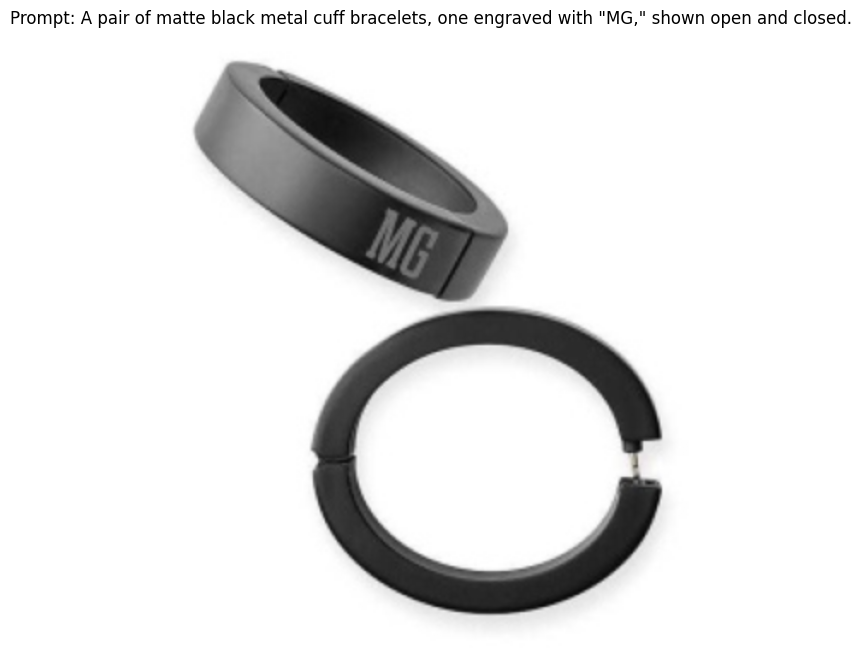

In [ ]:
import matplotlib.pyplot as plt

def show_sample(dataset, index=1):
    image, prompt = dataset[index]

    image = image * 0.5 + 0.5  

    image = image.permute(1, 2, 0).numpy()  

    image = image.clip(0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Prompt: {prompt}", fontsize=12)
    plt.axis('off')  # Hide axes
    plt.show()

show_sample(dataset, index=2)


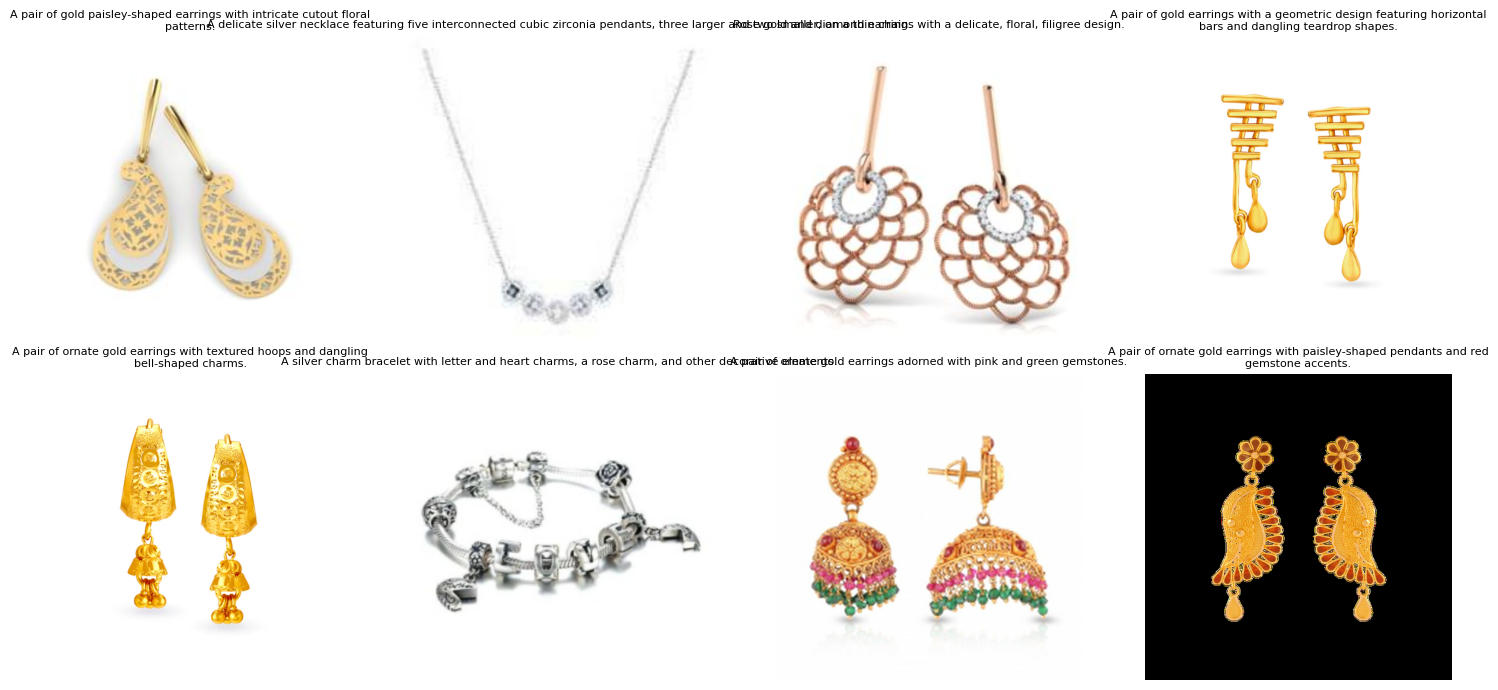

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np

def denormalize(tensor):
    """Denormalize image tensor (from [-1, 1] to [0, 1])"""
    tensor = tensor.clone() 
    tensor = tensor * 0.5 + 0.5 
    return tensor.clamp(0, 1)

data_iter = iter(dataloader)
images, prompts = next(data_iter)

images = denormalize(images)

num_images = min(8, len(images))  
rows = 2
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 7))
axes = axes.flatten()

for i in range(num_images):
    img = images[i].permute(1, 2, 0).numpy()  
    axes[i].imshow(img)
    axes[i].set_title(prompts[i], fontsize=8, wrap=True)  
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
pipe.to(device)

pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.text_encoder_2.requires_grad_(False)

optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=learning_rate)

scaler = torch.amp.GradScaler('cuda')  


Loading pipeline components...: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]


cuda


In [ ]:
import os
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast
from torch.amp import GradScaler
from diffusers import StableDiffusionXLPipeline
from torchvision import transforms
from PIL import Image
import logging
import time

# Setup logging
logging.basicConfig(level=logging.INFO)

# Paths and hyperparameters
dataset_path = "Dataset"
metadata_file = "Dataset/dataset_labels.csv"
save_dir = "fine-tuned-weights"
image_size = 512
batch_size = 16
accumulation_steps = 4
learning_rate = 1e-5
num_epochs = 10

# Create save directory
os.makedirs(save_dir, exist_ok=True)

# Load dataframe
df = pd.read_csv(metadata_file)
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(dataset_path, x))

# Define transform
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# JewelryDataset with timing
class JewelryDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        start_time = time.time()
        image_path = self.df.iloc[idx]["image_path"]
        prompt = self.df.iloc[idx]["description"]
        try:
            image = Image.open(image_path).convert("RGB")
            print(f"Image {image_path} loaded in {time.time() - start_time:.2f}s")
            start_time = time.time()
            image = self.transform(image)
            print(f"Image {image_path} transformed in {time.time() - start_time:.2f}s")
        except Exception as e:
            logging.error(f"Error loading image {image_path}: {e}")
            image = torch.zeros((3, image_size, image_size))
        return image, prompt

# Create dataset and dataloader
dataset = JewelryDataset(df, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Initialize pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
pipe.to(device)

# Freeze VAE and text encoders
pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.text_encoder_2.requires_grad_(False)

# Optimizer
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=learning_rate)

# GradScaler for mixed precision
scaler = torch.amp.GradScaler('cuda')

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    print(f"Starting epoch {epoch+1}")
    for step, batch in enumerate(dataloader):
        loop_start_time = time.time()
        images, prompts = batch
        images = images.to(device, dtype=torch.float16)
        
        # Encode images to latents
        with torch.no_grad():
            latents = pipe.vae.encode(images).latent_dist.sample() * pipe.vae.config.scaling_factor
        print(f"Step {step+1}: VAE encoding: {time.time() - loop_start_time:.2f}s")
        
        # Encode prompts
        start_time = time.time()
        text_inputs = pipe.tokenizer(
            prompts,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        text_inputs2 = pipe.tokenizer_2(
            prompts,
            padding="max_length",
            max_length=pipe.tokenizer_2.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        with torch.no_grad():
            text_outputs1 = pipe.text_encoder(
                text_inputs.input_ids.to(device),
                attention_mask=text_inputs.attention_mask.to(device),
                output_hidden_states=True
            )
            text_outputs2 = pipe.text_encoder_2(
                text_inputs2.input_ids.to(device),
                attention_mask=text_inputs2.attention_mask.to(device),
                output_hidden_states=True
            )
            # Use last hidden states from both encoders
            text_embeddings1 = text_outputs1.hidden_states[-1]  # CLIP last hidden state
            text_embeddings2 = text_outputs2.hidden_states[-1]  # OpenCLIP last hidden state
            # Use text_embeds for added_cond_kwargs
            text_embeds = text_outputs2.text_embeds  # Pooled embeddings from OpenCLIP
        
        print(f"Step {step+1}: Text encoding: {time.time() - start_time:.2f}s")
        
        # Sample timesteps
        start_time = time.time()
        timesteps = torch.randint(
            0, pipe.scheduler.num_train_timesteps, (latents.shape[0],), device=device
        )
        noise = torch.randn_like(latents)
        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
        print(f"Step {step+1}: Noise addition: {time.time() - start_time:.2f}s")
        
        # Prepare added_cond_kwargs
        start_time = time.time()
        batch_size = noisy_latents.shape[0]
        original_size = (image_size, image_size)
        target_size = original_size
        crops_coords_top_left = (0, 0)
        time_ids = torch.tensor(
            [original_size + crops_coords_top_left + target_size] * batch_size,
            device=device,
            dtype=torch.float32
        )
        added_cond_kwargs = {
            "text_embeds": text_embeds.to(dtype=torch.float16),
            "time_ids": time_ids
        }
        print(f"Step {step+1}: Cond kwargs prep: {time.time() - start_time:.2f}s")
        
        # Predict noise
        start_time = time.time()
        with autocast():
            noise_pred = pipe.unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=text_embeddings2,  # Use OpenCLIP embeddings
                added_cond_kwargs=added_cond_kwargs
            ).sample
        print(f"Step {step+1}: UNet forward: {time.time() - start_time:.2f}s")
        
        # Compute loss
        start_time = time.time()
        loss = F.mse_loss(noise_pred, noise)
        epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Step {step+1}, Loss: {loss.item():.4f}")
        print(f"Step {step+1}: Loss computation: {time.time() - start_time:.2f}s")
        
        # Backward pass
        start_time = time.time()
        scaler.scale(loss).backward()
        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(dataloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        print(f"Step {step+1}: Backward and optimization: {time.time() - start_time:.2f}s")
        print(f"Step {step+1}: Total time: {time.time() - loop_start_time:.2f}s")
        print("-" * 50)
    
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
    torch.save(pipe.unet.state_dict(), f"{save_dir}/unet_epoch_{epoch+1}.pth")
    print(f"Saved UNet weights for epoch {epoch+1}")
    
    if (epoch + 1) in [3, 5, 10]:
        pipe.save_pretrained(f"{save_dir}/pipeline_epoch_{epoch+1}")
        print(f"Saved full pipeline for epoch {epoch+1}")

print("Fine-tuning completed!")

Loading pipeline components...: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


Using device: cuda
Starting epoch 1
Image stable-diffusion\jewellery_dataset\necklace/J4PQC3WA3R5W.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\necklace/J4PQC3WA3R5W.jpg transformed in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/earring_234.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\earring_best/earring_234.jpg transformed in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/024_023.png loaded in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/024_023.png transformed in 0.00s
Image stable-diffusion\jewellery_dataset\earring_best/044_011.png loaded in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/044_011.png transformed in 0.01s
Image stable-diffusion\jewellery_dataset\necklace/8FJ4JYQGA4KA.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\necklace/8FJ4JYQGA4KA.jpg transformed in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/038_063.png loaded in 0.01s
Image stable-diffusion\je

C:\Users\rohan-graph-rkk\Desktop\Stable_Diffusion\diffusers\src\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'EulerDiscreteScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'EulerDiscreteScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
C:\Users\rohan-graph-rkk\AppData\Local\Temp\ipykernel_102148\2936068488.py:168: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1232x1280 and 2048x640)

In [5]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from diffusers import StableDiffusionXLPipeline
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)

# Initialize pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
pipe.to(device)

# Freeze VAE and text encoders
pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.text_encoder_2.requires_grad_(False)

# Hyperparameters (adjusted for stability)
learning_rate = 1e-6
num_epochs = 10
accumulation_steps = 4
save_dir = "fine-tuned-weights"

# Optimizer with smaller learning rate
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=learning_rate)

# GradScaler for mixed precision
scaler = GradScaler()

# Assume dataloader is defined (provides images and prompts)
# Example: dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    print(f"Starting epoch {epoch+1}")
    for step, batch in enumerate(dataloader):
        images, prompts = batch
        # Normalize images to [-1, 1]
        images = (images * 2) - 1
        images = images.to(device, dtype=torch.float16)
        
        # Skip invalid images
        if not torch.isfinite(images).all():
            print("Invalid images. Skipping batch.")
            continue
        
        # Encode images to latents
        with torch.no_grad():
            latents = pipe.vae.encode(images).latent_dist.sample() * pipe.vae.config.scaling_factor
        
        # Skip if latents are invalid
        if not torch.isfinite(latents).all():
            print("Invalid latents. Skipping batch.")
            continue
        
        # Encode prompts
        text_inputs = pipe.tokenizer(
            prompts,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        text_inputs2 = pipe.tokenizer_2(
            prompts,
            padding="max_length",
            max_length=pipe.tokenizer_2.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        with torch.no_grad():
            text_embeddings1 = pipe.text_encoder(
                text_inputs.input_ids.to(device),
                attention_mask=text_inputs.attention_mask.to(device)
            )[0]
            text_outputs2 = pipe.text_encoder_2(
                text_inputs2.input_ids.to(device),
                attention_mask=text_inputs2.attention_mask.to(device)
            )
            text_embeddings2 = text_outputs2[0]  # Hidden states
            text_embeds = text_outputs2[1]  # Pooled output for added_cond_kwargs
            
            # Ensure both embeddings are 3D and compatible for concatenation
            if text_embeddings2.dim() == 2:
                text_embeddings2 = text_embeddings2.unsqueeze(1).expand(-1, text_embeddings1.size(1), -1)
            elif text_embeddings1.dim() == 2:
                text_embeddings1 = text_embeddings1.unsqueeze(1).expand(-1, text_embeddings2.size(1), -1)
            elif text_embeddings1.size(1) != text_embeddings2.size(1):
                max_seq_len = max(text_embeddings1.size(1), text_embeddings2.size(1))
                if text_embeddings1.size(1) < max_seq_len:
                    text_embeddings1 = F.pad(text_embeddings1, (0, 0, 0, max_seq_len - text_embeddings1.size(1)))
                if text_embeddings2.size(1) < max_seq_len:
                    text_embeddings2 = F.pad(text_embeddings2, (0, 0, 0, max_seq_len - text_embeddings2.size(1)))
            
            # Concatenate the embeddings
            text_embeddings = torch.cat([text_embeddings1, text_embeddings2], dim=-1)
        
        # Sample timesteps
        timesteps = torch.randint(
            0, pipe.scheduler.num_train_timesteps, (latents.shape[0],), device=device
        )
        
        # Add noise
        noise = torch.randn_like(latents)
        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
        
        # Skip if noise or noisy_latents are invalid
        if not torch.isfinite(noise).all() or not torch.isfinite(noisy_latents).all():
            print("Invalid noise or noisy_latents. Skipping batch.")
            continue
        
        # Predict noise
        with autocast():
            # Prepare added_cond_kwargs
            batch_size = noisy_latents.shape[0]
            # Use fixed time_ids for stability (adjust based on your dataset)
            time_ids = torch.tensor([[1024, 1024, 0, 0, 1024, 1024]] * batch_size, device=device, dtype=torch.float16)
            
            # Ensure text_embeds is 2D
            if text_embeds.dim() == 3:
                if text_embeds.size(1) == 1:
                    text_embeds = text_embeds.squeeze(1)
                else:
                    text_embeds = text_embeds.mean(dim=1)
            elif text_embeds.dim() > 2:
                text_embeds = text_embeds.view(batch_size, -1)
            
            added_cond_kwargs = {
                "text_embeds": text_embeds,
                "time_ids": time_ids
            }
            
            # Call UNet
            noise_pred = pipe.unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=text_embeddings,
                added_cond_kwargs=added_cond_kwargs
            ).sample
        
        # Compute loss
        loss = F.mse_loss(noise_pred, noise)
        
        # Skip if loss is nan
        if torch.isnan(loss):
            print("Loss is NaN. Skipping batch.")
            continue
        
        epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Step {step+1}, Loss: {loss.item():.4f}")
        
        # Backward pass with gradient accumulation
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(pipe.unet.parameters(), max_norm=1.0)  # Clip gradients
        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(dataloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
    
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
    
    # Save UNet weights after each epoch
    torch.save(pipe.unet.state_dict(), f"{save_dir}/unet_epoch_{epoch+1}.pth")
    logging.info(f"Saved UNet weights for epoch {epoch+1}")
    print(f"Saved UNet weights for epoch {epoch+1}")
    
    # Save entire pipeline at epochs 3, 5, 10
    if (epoch + 1) in [3, 5, 10]:
        pipe.save_pretrained(f"{save_dir}/pipeline_epoch_{epoch+1}")
        logging.info(f"Saved full pipeline for epoch {epoch+1}")
        print(f"Saved full pipeline for epoch {epoch+1}")

logging.info("Fine-tuning completed!")

Loading pipeline components...: 100%|██████████| 7/7 [00:09<00:00,  1.43s/it]


Using device: cuda


C:\Users\rohan-graph-rkk\AppData\Local\Temp\ipykernel_102148\3202718763.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting epoch 1
Image stable-diffusion\jewellery_dataset\bracelet/bracelet_306.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\bracelet/bracelet_306.jpg transformed in 0.01s
Image stable-diffusion\jewellery_dataset\necklace/EPL0QTEDN8UZ.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\necklace/EPL0QTEDN8UZ.jpg transformed in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/013_010.png loaded in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/013_010.png transformed in 0.00s
Image stable-diffusion\jewellery_dataset\ring_best/ring_067.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\ring_best/ring_067.jpg transformed in 0.01s
Image stable-diffusion\jewellery_dataset\necklace/necklace_261.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\necklace/necklace_261.jpg transformed in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/028_016.png loaded in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/

INFO:root:Saved UNet weights for epoch 1


Saved UNet weights for epoch 1
Starting epoch 2
Image stable-diffusion\jewellery_dataset\earring_best/034_005.png loaded in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/034_005.png transformed in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/045_067.png loaded in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/045_067.png transformed in 0.01s
Image stable-diffusion\jewellery_dataset\necklace/necklace_191.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\necklace/necklace_191.jpg transformed in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/024_100.png loaded in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/024_100.png transformed in 0.00s
Image stable-diffusion\jewellery_dataset\necklace/EA24TCSCXF52.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\necklace/EA24TCSCXF52.jpg transformed in 0.03s
Image stable-diffusion\jewellery_dataset\earring_best/046_037.png loaded in 0.01s
Image stable-diffusio

INFO:root:Saved UNet weights for epoch 2


Saved UNet weights for epoch 2
Starting epoch 3
Image stable-diffusion\jewellery_dataset\bracelet/bracelet_275.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\bracelet/bracelet_275.jpg transformed in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/038_044.png loaded in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/038_044.png transformed in 0.00s
Image stable-diffusion\jewellery_dataset\earring_best/002_016.png loaded in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/002_016.png transformed in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/024_100.png loaded in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/024_100.png transformed in 0.00s
Image stable-diffusion\jewellery_dataset\ring_best/ring_036.jpg loaded in 0.00s
Image stable-diffusion\jewellery_dataset\ring_best/ring_036.jpg transformed in 0.01s
Image stable-diffusion\jewellery_dataset\earring_best/015_012.png loaded in 0.01s
Image stable-diffusion\jewe

INFO:root:Saved UNet weights for epoch 3


Saved UNet weights for epoch 3


SafetensorError: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })

In [8]:
import torch
from diffusers import StableDiffusionXLPipeline
import os
from PIL import Image
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)

# Define paths
checkpoint_dir = "fine-tuned-weights"
output_dir = "./test_outputs_jewelry"
os.makedirs(output_dir, exist_ok=True)

# Test prompts tailored for jewelry generation
test_prompts = [
    "A delicate gold bracelet with sapphire gemstones, modern design, sparkling under soft lighting",
    "A pair of vintage silver hoop earrings with intricate filigree patterns, elegant and detailed",
    "A luxurious diamond necklace with a heart-shaped pendant, set in white gold, on a velvet background",
    "A bold rose gold ring with an emerald centerpiece, contemporary style, highly detailed",
    "A set of dangling chandelier earrings with rubies and pearls, ornate baroque design, glowing softly",
    "A minimalist titanium bracelet with geometric patterns, futuristic aesthetic, studio lighting",
    "A multi-strand pearl necklace with a gold clasp, classic and timeless, displayed on a silk surface",
    "A stackable silver ring set with colorful gemstones, bohemian style, vibrant and artistic"
]

# Negative prompt to improve quality
negative_prompt = "blurry, low quality, distorted, unrealistic, poor lighting, unnatural textures"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16
)
pipe.to(device)

# Load fine-tuned UNet weights from epoch 3
unet_checkpoint_path = os.path.join(checkpoint_dir, "unet_epoch_3.pth")
if os.path.exists(unet_checkpoint_path):
    pipe.unet.load_state_dict(torch.load(unet_checkpoint_path, map_location=device))
    logging.info(f"Loaded UNet weights from {unet_checkpoint_path}")
else:
    raise FileNotFoundError(f"UNet checkpoint not found at {unet_checkpoint_path}")

# Alternatively, load the full pipeline if saved (uncomment if preferred)
# pipeline_checkpoint_path = os.path.join(checkpoint_dir, "pipeline_epoch_3")
# if os.path.exists(pipeline_checkpoint_path):
#     pipe = StableDiffusionXLPipeline.from_pretrained(
#         pipeline_checkpoint_path,
#         torch_dtype=torch.float16
#     ).to(device)
#     logging.info(f"Loaded full pipeline from {pipeline_checkpoint_path}")
# else:
#     raise FileNotFoundError(f"Pipeline checkpoint not found at {pipeline_checkpoint_path}")

# Generate images for each prompt
for idx, prompt in enumerate(test_prompts):
    print(f"Generating image for prompt: {prompt}")
    with torch.no_grad():
        # Generate image
        image = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=50,  # Balance quality and speed
            guidance_scale=7.5,     # Ensure prompt adherence
            height=1024,            # SDXL default resolution
            width=1024
        ).images[0]
    
    # Save the image
    output_path = os.path.join(output_dir, f"jewelry_image_{idx+1}.png")
    image.save(output_path)
    logging.info(f"Saved generated image to {output_path}")
    print(f"Saved image to {output_path}")

logging.info("Jewelry image generation testing completed!")

Using device: cuda


Loading pipeline components...: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
INFO:root:Loaded UNet weights from fine-tuned-weights\unet_epoch_3.pth


Generating image for prompt: A delicate gold bracelet with sapphire gemstones, modern design, sparkling under soft lighting


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]
INFO:root:Saved generated image to ./test_outputs_jewelry\jewelry_image_1.png


Saved image to ./test_outputs_jewelry\jewelry_image_1.png
Generating image for prompt: A pair of vintage silver hoop earrings with intricate filigree patterns, elegant and detailed


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]
INFO:root:Saved generated image to ./test_outputs_jewelry\jewelry_image_2.png


Saved image to ./test_outputs_jewelry\jewelry_image_2.png
Generating image for prompt: A luxurious diamond necklace with a heart-shaped pendant, set in white gold, on a velvet background


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]
INFO:root:Saved generated image to ./test_outputs_jewelry\jewelry_image_3.png


Saved image to ./test_outputs_jewelry\jewelry_image_3.png
Generating image for prompt: A bold rose gold ring with an emerald centerpiece, contemporary style, highly detailed


100%|██████████| 50/50 [00:12<00:00,  4.15it/s]
INFO:root:Saved generated image to ./test_outputs_jewelry\jewelry_image_4.png


Saved image to ./test_outputs_jewelry\jewelry_image_4.png
Generating image for prompt: A set of dangling chandelier earrings with rubies and pearls, ornate baroque design, glowing softly


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]
INFO:root:Saved generated image to ./test_outputs_jewelry\jewelry_image_5.png


Saved image to ./test_outputs_jewelry\jewelry_image_5.png
Generating image for prompt: A minimalist titanium bracelet with geometric patterns, futuristic aesthetic, studio lighting


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]
INFO:root:Saved generated image to ./test_outputs_jewelry\jewelry_image_6.png


Saved image to ./test_outputs_jewelry\jewelry_image_6.png
Generating image for prompt: A multi-strand pearl necklace with a gold clasp, classic and timeless, displayed on a silk surface


100%|██████████| 50/50 [00:11<00:00,  4.49it/s]
INFO:root:Saved generated image to ./test_outputs_jewelry\jewelry_image_7.png


Saved image to ./test_outputs_jewelry\jewelry_image_7.png
Generating image for prompt: A stackable silver ring set with colorful gemstones, bohemian style, vibrant and artistic


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]
INFO:root:Saved generated image to ./test_outputs_jewelry\jewelry_image_8.png
INFO:root:Jewelry image generation testing completed!


Saved image to ./test_outputs_jewelry\jewelry_image_8.png


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, StableDiffusionXLPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import logging
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuration
dataset_path = "stable-diffusion/jewellery_dataset"
metadata_file = "stable-diffusion/metadata.csv"
save_dir = "fine-tuned-weights"
image_size = 512
batch_size = 8  # Increased batch size for better GPU utilization
learning_rate = 1e-5
num_epochs = 10

# Setup directories
os.makedirs(save_dir, exist_ok=True)

# Load metadata
df = pd.read_csv(metadata_file)
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(dataset_path, x))

# Image transformation
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Dataset class with enhanced validation
class JewelryDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]["image_path"]
        prompt = self.df.iloc[idx]["description"]
        try:
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)
            if image.isnan().any():
                raise ValueError("NaN values in image tensor")
            return image, prompt
        except Exception as e:
            logging.error(f"Skipping invalid sample {image_path}: {e}")
            return None

# Create dataset
dataset = JewelryDataset(df, transform)


c:\Users\rohan-graph-rkk\Desktop\Stable_Diffusion\stable_diff\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


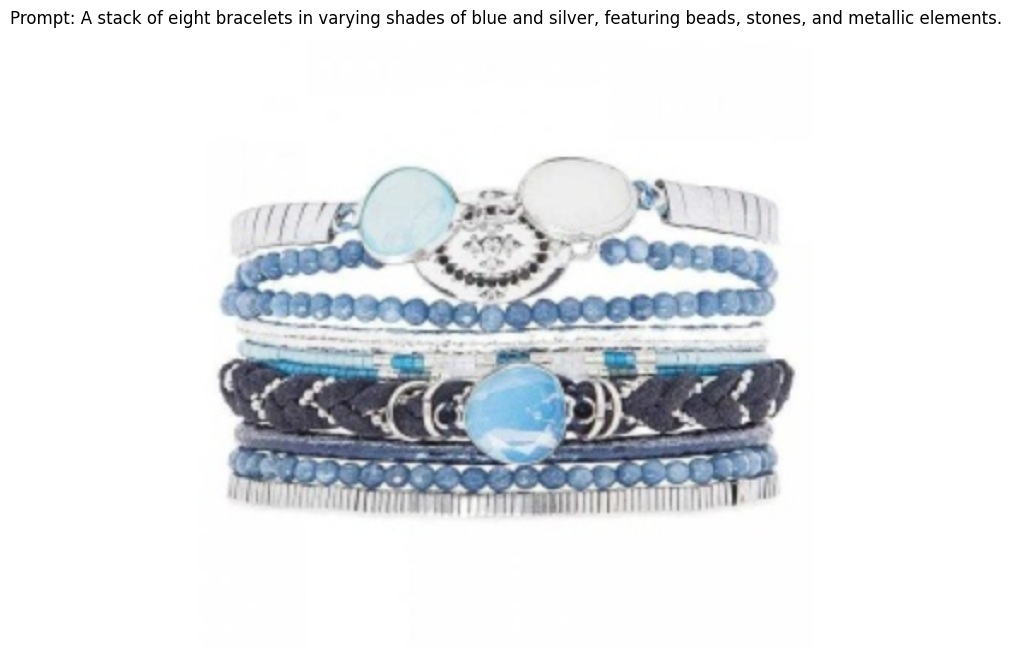

In [2]:
import matplotlib.pyplot as plt

def show_sample(dataset, index=1):
    # Get a sample (image tensor and prompt)
    image, prompt = dataset[index]

    # Denormalize the image (from [-1, 1] to [0, 1])
    image = image * 0.5 + 0.5  # Reverse normalization: (x * std + mean)

    # Convert from PyTorch tensor (C, H, W) to NumPy (H, W, C) for matplotlib
    image = image.permute(1, 2, 0).numpy()  # Change from (3, 512, 512) to (512, 512, 3)

    # Clip values to ensure they're in [0, 1] (in case of small numerical errors)
    image = image.clip(0, 1)

    # Display the image with the prompt
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Prompt: {prompt}", fontsize=12)
    plt.axis('off')  # Hide axes
    plt.show()

# Show a sample (e.g., the first item in the dataset)
show_sample(dataset, index=1)


In [3]:

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    
    images = torch.stack([item[0] for item in batch])
    prompts = [item[1] for item in batch]
    
    # Tokenization
    tokenizer_outputs = tokenizer(
        prompts,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    
    tokenizer_2_outputs = tokenizer_2(
        prompts,
        padding="max_length",
        max_length=tokenizer_2.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    
    return {
        'pixel_values': images,
        'input_ids': tokenizer_outputs.input_ids,
        'attention_mask': tokenizer_outputs.attention_mask,
        'input_ids_2': tokenizer_2_outputs.input_ids,
        'attention_mask_2': tokenizer_2_outputs.attention_mask,
    }

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "stabilityai/stable-diffusion-xl-base-1.0"

# Load models with full precision and GPU optimization
def load_model_with_mem_optim(model_class, model_id, subfolder=None):
    return model_class.from_pretrained(
        model_id,
        subfolder=subfolder,
        torch_dtype=torch.float32,
        low_cpu_mem_usage=True,
        use_safetensors=True
    ).to(device)

# Load components
print("Loading VAE...")
vae = load_model_with_mem_optim(AutoencoderKL, model_id, "vae")

print("Loading text encoders...")
text_encoder = load_model_with_mem_optim(CLIPTextModel, model_id, "text_encoder")
text_encoder_2 = load_model_with_mem_optim(CLIPTextModel, model_id, "text_encoder_2")

print("Loading UNet...")
unet = load_model_with_mem_optim(UNet2DConditionModel, model_id, "unet")

print("Loading tokenizers...")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
tokenizer_2 = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer_2")

# Load scheduler
print("Loading Scheduler.....")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
# Freeze non-trainable components
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
text_encoder_2.requires_grad_(False)
unet.train()

# Configure training optimizations
unet.enable_gradient_checkpointing()
torch.cuda.empty_cache()

# Training setup
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
scaler = GradScaler()
train_dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=4
)
print("Starting training.....")
# Enhanced training loop with GPU memory management


Loading VAE...
Loading text encoders...
Loading UNet...
Loading tokenizers...
Loading Scheduler.....
Starting training.....


In [4]:
import matplotlib.pyplot as plt

def show_sample(dataset, index=1):
    # Get a sample (image tensor and prompt)
    image, prompt = dataset[index]

    # Denormalize the image (from [-1, 1] to [0, 1])
    image = image * 0.5 + 0.5  # Reverse normalization: (x * std + mean)

    # Convert from PyTorch tensor (C, H, W) to NumPy (H, W, C) for matplotlib
    image = image.permute(1, 2, 0).numpy()  # Change from (3, 512, 512) to (512, 512, 3)

    # Clip values to ensure they're in [0, 1] (in case of small numerical errors)
    image = image.clip(0, 1)

    # Display the image with the prompt
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Prompt: {prompt}", fontsize=12)
    plt.axis('off')  # Hide axes
    plt.show()

# Show a sample (e.g., the first item in the dataset)
show_sample(train_dataloader, index=1)


TypeError: 'DataLoader' object is not subscriptable

In [ ]:

for epoch in range(num_epochs):
    unet.train()
    print('Unet training')
    torch.cuda.empty_cache()
    print("GPU available")
    for step, batch in enumerate(train_dataloader):
        # if batch is None:
        #     continue
            
        # Move data to GPU in one go
        print('Moving data to gpu')
        pixel_values = batch['pixel_values'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        input_ids_2 = batch['input_ids_2'].to(device, non_blocking=True)
        attention_mask_2 = batch['attention_mask_2'].to(device, non_blocking=True)
        print('data to gpu completed')

        with autocast():
            print('autocast')
            # Forward passes with memory optimization
            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

            # Noise addition
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (latents.size(0),), device=device)
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)

            # Text embeddings
            with torch.no_grad():
                text_embeddings1 = text_encoder(input_ids, attention_mask=attention_mask)[0]
                text_outputs2 = text_encoder_2(input_ids_2, attention_mask=attention_mask_2)
                text_embeddings2 = text_outputs2[0]
                pooled_embeddings = text_outputs2.pooler_output

            text_embeddings = torch.cat([text_embeddings1, text_embeddings2], dim=-1)

            # Prepare additional conditioning
            add_time_ids = torch.tensor(
                [[image_size, image_size, 0, 0, image_size, image_size]] * latents.size(0),
                dtype=torch.float32,
                device=device
            )

            # UNet forward
            noise_pred = unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=text_embeddings,
                added_cond_kwargs={"text_embeds": pooled_embeddings, "time_ids": add_time_ids}
            ).sample

            # Calculate loss
            loss = nn.functional.mse_loss(noise_pred, noise)

        # Backpropagation with memory optimization
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        # Memory cleanup
        del noise_pred, noise, latents, text_embeddings
        torch.cuda.empty_cache()

        print(f"Epoch {epoch+1}/{num_epochs} | Step {step} | Loss: {loss.item():.4f}")

    # Save checkpoint
    checkpoint_path = os.path.join(save_dir, f"unet_epoch.pth")
    torch.save(unet.state_dict(), checkpoint_path)
    print(f"Saved checkpoint to {checkpoint_path}")

# Save final model
try:
    pipeline = StableDiffusionXLPipeline(
        vae=vae,
        text_encoder=text_encoder,
        text_encoder_2=text_encoder_2,
        tokenizer=tokenizer,
        tokenizer_2=tokenizer_2,
        unet=unet,
        scheduler=scheduler,
    )
    pipeline.save_pretrained(os.path.join(save_dir, "full_model"))
    print("Full model saved successfully!")
except Exception as e:
    print(f"Error saving final model: {e}")

In [ ]:
import torch
import gc

def clear_gpu_memory():
    # Delete all tensor references
    for obj in globals().copy():
        if isinstance(globals()[obj], torch.Tensor) and globals()[obj].is_cuda:
            del globals()[obj]
    
    # Run garbage collection
    gc.collect()
    
    # Clear the PyTorch CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU memory cleared")
    else:
        print("No GPU available")

# Example usage
clear_gpu_memory()

In [ ]:
print(f"Total samples in dataset: {len(dataset)}")
for i in range(5):
    sample = dataset[i]
    print(f"Sample {i} loaded:", sample is not None)
